# Bacteriocin Lipid Analysis

Looking at protein-lipid interactions taken from MemProtMD (http://memprotmd.bioch.ox.ac.uk/)

### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as s
import math as m
import random

### Helper Modules

In [ ]:
# Convert resName to one letter amino acid code
convert_to_one_letter_dic = {"ALA":"A", "ARG":"R", "ASN":"N", "ASP":"D", "CYS":"C", "GLU":"E", "GLN":"Q", "GLY":"G",\
                            "HSD":"H", "HIS": "H", "HSE":"H", "ILE": "I", "LEU": "L", "LYS":"K", "MET":"M", "PHE":"F", "PRO":"P",\
                            "SER":"S", "THR":"T", "TRP":"W", "TYR":"Y", "VAL":"V"}
def convert_to_one_letter(string):
    amino_acid = str(string[0:3])
    return convert_to_one_letter_dic[amino_acid]

In [ ]:
# Get headers to plot significant residues
def get_headers(dataframe):
    """"
    Function gets headers for residues
    """"
    x_axis_headers = []
    for row in dataframe.itertuples():
        if row._2 not in x_axis_headers:
            x_axis_headers.append(row._2)
    
    return x_axis_headers

In [ ]:
# Get significant residues
def get_sig_residues(x_axis_headers, dataframe):
    """
    Function gets list of significant resides to create new dataframe
    """
    resSeq_list = []
    position_list = []
    chain_list = []
    fraction_frames_list = []
    for row in dataframe.itertuples():
        if row._2 in x_axis_headers:
            resSeq_list.append(row.resSeq)
            position_list.append(row._2)
            chain_list.append(row.chainID)
            fraction_frames_list.append(row.Fraction_Frames)
    return resSeq_list, position_list, chain_list, fraction_frames_list

In [ ]:
def chain_dic(data):
    """
    Function takes a dataframe and returns chainA and chainB lipid interaction values as a dictionary
    by amino acid position. Output is fed into chain_pair_vals function.
    """
    chain_A = dict()
    chain_B = dict()
    for row in data.itertuples():
        if row.chainID == "A":
            chain_A[row._2] = row.Fraction_Frames
        elif row.chainID == "B":
            chain_B[row._2] = row.Fraction_Frames
    return chain_A, chain_B

In [ ]:
def chain_dic_vals(chain_A_dic,chain_B_dic):
    """
    Function takes output from chain_dic and returns a list of chain A and chain B values for input into
    permutation test
    """
    chain_A_vals = []
    chain_B_vals = []
    for v1 in chain_A_dic.values():
        chain_A_vals.append(v1)
    for v2 in chain_B_dic.values():
        chain_B_vals.append(v2)
    return chain_A_vals, chain_B_vals

In [ ]:
def chain_pair_vals(chain_A,chain_B):
    """
    Function takes dictionary of chain values for chain A and B and returns the difference
    when the amino acids match. Else searches for instances where amino acid is unique to chain A or B.
    """
    A_B_diff = dict()
    unique_A = dict()
    unique_B = dict()
    for k1,v1 in chain_A.items():
        for k2,v2 in chain_B.items():
            if k1 == k2:
                diff = 0
                diff = v1 - v2
                A_B_diff[k1] = diff
            elif k1 not in chain_B.keys():
                unique_A[k1] = v1
    for k3,v3 in chain_B.items():
        if k3 not in chain_A.keys():
            unique_B[k3] = v3
    return A_B_diff, unique_A, unique_B

In [ ]:
def p_val(difference_dic,iterations,permute_results):
    """
    Function takes the difference in chain values (as a dic) and permutation results
    and returns the p-value for that difference.
    """
    results_array = np.array(permute_results)
    p_val_dict = dict()
    for v1, v2 in difference_dic.items():
        if v2 < 0:
            diffCount = len(np.where(np.sort(results_array) <= v2)[0])
            p_val = float(diffCount)/float(iterations)
            p_val_dict[v1] = p_val
        else:
            diffCount = len(np.where(np.sort(results_array) >= v2)[0])
            p_val = float(diffCount)/float(iterations)
            p_val_dict[v1] = p_val
    return p_val_dict

In [ ]:
def sig_p_val(p_val_dic,sig_level):
    num_tests = int(len(p_val_dic))
    bonferroni = sig_level/num_tests
    sig_vals = dict()
    for key,val in p_val_dic.items():
        if val <= bonferroni:
            sig_vals[key] = val
    return sig_vals

In [ ]:
def montecarlo(data,n_samples,iterations):
    random.seed(42) # set seed
    count = 0
    median_diff_list = [] #store median difference values for plotting
    while count < iterations:
        # randomly select samples from the list without replacement
        # calculate mean difference - smoother distn than calc median diff
        sample_1 = random.sample(data, n_samples)
        sample_2 = random.sample(data, n_samples)
        median_diff = np.mean(sample_1) - np.mean(sample_2)
        median_diff_list.append(median_diff)
        count += 1
        
    return median_diff_list

### Import Data

In [2]:
prot_6v9z = pd.read_csv("data/6v9z_default_dppc-by-resid.csv") # Hungateiclostridium thermocellum ATCC 27405 PCAT1
prot_7t55 = pd.read_csv("data/7t55_default_dppc-by-resid.csv") # Acetivibrio thermocellus PCAT1 inward-facing wide conformation under ATP turnover condition
prot_7t56 = pd.read_csv("data/7t56_default_dppc-by-resid.csv") # Acetivibrio thermocellus PCAT1 inward-facing intermediate conformation under ATP turnover condition
prot_7t57 = pd.read_csv("data/7t57_default_dppc-by-resid.csv") # Acetivibrio thermocellus PCAT1 inward-facing narrow conformation under ATP turnover condition
prot_4pl0 = pd.read_csv("data/4pl0_default_dppc-by-resid.csv") # Escherichia coli McjD outward occluded state
prot_4s0f = pd.read_csv("data/4s0f_default_dppc-by-resid.csv") # Hungateiclostridium thermocellum ATCC 27405 PCAT1 with ATPgS
prot_5ofp = pd.read_csv("data/5ofp_default_dppc-by-resid.csv") # Escherichia coli McjD inward occluded state
prot_5l22 = pd.read_csv("data/5l22_default_dppc-by-resid.csv") # Aquifex aeolicus (strain VF5) HlyB
prot_5eg1 = pd.read_csv("data/5eg1_default_dppc-by-resid.csv") # Escherichia coli McjD with resolved lipid

### Annotate

In [4]:
prot_6v9z["resCode"] = prot_6v9z["resName"].apply(convert_to_one_letter) #convert 6v9z to one letter aa code
prot_6v9z["Joint Position"] = prot_6v9z["resCode"] + prot_6v9z["resSeq"].astype(str) #6v9z aa code and position
prot_7t55["resCode"] = prot_7t55["resName"].apply(convert_to_one_letter) #convert 7t55 to one letter aa code
prot_7t55["Joint Position"] = prot_7t55["resCode"] + prot_7t55["resSeq"].astype(str) #7t55 aa code and position
prot_7t56["resCode"] = prot_7t56["resName"].apply(convert_to_one_letter) #convert 7t56 to one letter aa code
prot_7t56["Joint Position"] = prot_7t56["resCode"] + prot_7t56["resSeq"].astype(str) #7t56 aa code and position
prot_7t57["resCode"] = prot_7t57["resName"].apply(convert_to_one_letter) #convert 7t57 to one letter aa code
prot_7t57["Joint Position"] = prot_7t57["resCode"] + prot_7t57["resSeq"].astype(str) #7t57 aa code and position
prot_5l22["resCode"] = prot_5l22["resName"].apply(convert_to_one_letter) #convert 5l22 to one letter aa code
prot_5l22["Joint Position"] = prot_5l22["resCode"] + prot_5l22["resSeq"].astype(str) #5l22 aa code and position
prot_4pl0["resCode"] = prot_4pl0["resName"].apply(convert_to_one_letter) #convert 4pl0 to one letter aa code
prot_4pl0["Joint Position"] = prot_4pl0["resCode"] + prot_4pl0["resSeq"].astype(str) #4plo aa code and position
prot_4s0f["resCode"] = prot_4s0f["resName"].apply(convert_to_one_letter) #convert 4s0f to one letter aa code
prot_4s0f["Joint Position"] = prot_4s0f["resCode"] + prot_4s0f["resSeq"].astype(str) #4sof aa code and position
prot_5ofp["resCode"] = prot_5ofp["resName"].apply(convert_to_one_letter) #convert 5ofp to one letter aa code
prot_5ofp["Joint Position"] = prot_5ofp["resCode"] + prot_5ofp["resSeq"].astype(str) #5ofp aa code and position
prot_5eg1["resCode"] = prot_5eg1["resName"].apply(convert_to_one_letter) #convert 5ofp to one letter aa code
prot_5eg1["Joint Position"] = prot_5eg1["resCode"] + prot_5eg1["resSeq"].astype(str) #5ofp aa code and position

In [5]:
count_6v9z = prot_6v9z.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()
count_7t55 = prot_7t55.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()
count_7t56 = prot_7t56.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()
count_7t57 = prot_7t57.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()
count_5l22 = prot_5l22.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()
count_4pl0 = prot_4pl0.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()
count_4s0f = prot_4s0f.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()
count_5ofp = prot_5ofp.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()
count_5eg1 = prot_5eg1.groupby(["resSeq","Joint Position","chainID"])["group=Head"].sum().unstack()

In [6]:
#Reset index after unstack to get columns
count_6v9z.reset_index(inplace=True)
count_7t55.reset_index(inplace=True)
count_7t56.reset_index(inplace=True)
count_7t57.reset_index(inplace=True)
count_5l22.reset_index(inplace=True)
count_4pl0.reset_index(inplace=True)
count_4s0f.reset_index(inplace=True)
count_5ofp.reset_index(inplace=True)
count_5eg1.reset_index(inplace=True)

In [7]:
#Fill Na's with 0's
count_6v9z.fillna(value=0,inplace=True)
count_7t55.fillna(value=0,inplace=True)
count_7t56.fillna(value=0,inplace=True)
count_7t57.fillna(value=0,inplace=True)
count_5l22.fillna(value=0,inplace=True)
count_4pl0.fillna(value=0,inplace=True)
count_4s0f.fillna(value=0,inplace=True)
count_5ofp.fillna(value=0,inplace=True)
count_5eg1.fillna(value=0,inplace=True)

In [8]:
#Remove any columns with all 0's
count_6v9z = count_6v9z.loc[:, (count_6v9z != 0).any(axis=0)]
count_7t55 = count_7t55.loc[:, (count_7t55 != 0).any(axis=0)]
count_7t56 = count_7t56.loc[:, (count_7t56 != 0).any(axis=0)]
count_7t57 = count_7t57.loc[:, (count_7t57 != 0).any(axis=0)]
count_5l22 = count_5l22.loc[:, (count_5l22 != 0).any(axis=0)] 
count_4pl0 = count_4pl0.loc[:, (count_4pl0 != 0).any(axis=0)]
count_4s0f = count_4s0f.loc[:, (count_4s0f != 0).any(axis=0)]
count_5ofp = count_5ofp.loc[:, (count_5ofp != 0).any(axis=0)]
count_5eg1 = count_5eg1.loc[:, (count_5eg1 != 0).any(axis=0)]

In [9]:
#remove rows with 0 for A or B
count_6v9z = count_6v9z.loc[(count_6v9z[['A']] != 0).all(axis=1)] 
count_6v9z = count_6v9z.loc[(count_6v9z[['B']] != 0).all(axis=1)]
count_7t55 = count_7t55.loc[(count_7t55[['A']] != 0).all(axis=1)] 
count_7t55 = count_7t55.loc[(count_7t55[['B']] != 0).all(axis=1)]
count_7t56 = count_7t56.loc[(count_7t56[['A']] != 0).all(axis=1)] 
count_7t56 = count_7t56.loc[(count_7t56[['B']] != 0).all(axis=1)]
count_7t57 = count_7t57.loc[(count_7t57[['A']] != 0).all(axis=1)] 
count_7t57 = count_7t57.loc[(count_7t57[['B']] != 0).all(axis=1)]
count_5l22 = count_5l22.loc[(count_5l22[['A']] != 0).all(axis=1)] 
count_5l22 = count_5l22.loc[(count_5l22[['B']] != 0).all(axis=1)] 
count_4pl0 = count_4pl0.loc[(count_4pl0[['A']] != 0).all(axis=1)]
count_4pl0 = count_4pl0.loc[(count_4pl0[['B']] != 0).all(axis=1)]
count_4s0f = count_4s0f.loc[(count_4s0f[['A']] != 0).all(axis=1)]
count_4s0f = count_4s0f.loc[(count_4s0f[['B']] != 0).all(axis=1)]
count_5ofp = count_5ofp.loc[(count_5ofp[['A']] != 0).all(axis=1)] #PDB of 5ofp missing chain B
count_5eg1 = count_5eg1.loc[(count_5eg1[['A']] != 0).all(axis=1)]
count_5eg1 = count_5eg1.loc[(count_5eg1[['B']] != 0).all(axis=1)]

In [10]:
#Return dataframe where chainID is a single column - useful for later plotting with seaborn with hue as chainID
count_6v9z_melt = count_6v9z.melt(id_vars=["resSeq","Joint Position"], value_vars=["A","B"], value_name="Fraction_Frames")
count_7t55_melt = count_7t55.melt(id_vars=["resSeq","Joint Position"], value_vars=["A","B"], value_name="Fraction_Frames")
count_7t56_melt = count_7t56.melt(id_vars=["resSeq","Joint Position"], value_vars=["A","B"], value_name="Fraction_Frames")
count_7t57_melt = count_7t57.melt(id_vars=["resSeq","Joint Position"], value_vars=["A","B"], value_name="Fraction_Frames")
count_5l22_melt = count_5l22.melt(id_vars=["resSeq","Joint Position"], value_vars=["A","B"], value_name="Fraction_Frames")
count_4pl0_melt = count_4pl0.melt(id_vars=["resSeq","Joint Position"], value_vars=["A","B"], value_name="Fraction_Frames")
count_4s0f_melt = count_4s0f.melt(id_vars=["resSeq","Joint Position"], value_vars=["A","B"], value_name="Fraction_Frames")
count_5ofp_melt = count_5ofp.melt(id_vars=["resSeq","Joint Position"], value_vars=["A"], value_name="Fraction_Frames")
count_5eg1_melt = count_5eg1.melt(id_vars=["resSeq","Joint Position"], value_vars=["A","B"], value_name="Fraction_Frames")

In [ ]:
#Apply cut-off (0.05) to remove tiny values
count_6v9z_melt_sig = count_6v9z_melt[count_6v9z_melt["Fraction_Frames"] > 0.05] 
count_7t55_melt_sig = count_7t55_melt[count_7t55_melt["Fraction_Frames"] > 0.05] 
count_7t56_melt_sig = count_7t56_melt[count_7t56_melt["Fraction_Frames"] > 0.05]
count_7t57_melt_sig = count_7t57_melt[count_7t57_melt["Fraction_Frames"] > 0.05]
count_5l22_melt_sig = count_5l22_melt[count_5l22_melt["Fraction_Frames"] > 0.05] 
count_4pl0_melt_sig = count_4pl0_melt[count_4pl0_melt["Fraction_Frames"] > 0.05]
count_4s0f_melt_sig = count_4s0f_melt[count_4s0f_melt["Fraction_Frames"] > 0.05]
count_5ofp_melt_sig = count_5ofp_melt[count_5ofp_melt["Fraction_Frames"] > 0.05]
count_5eg1_melt_sig = count_5eg1_melt[count_5eg1_melt["Fraction_Frames"] > 0.015]

In [11]:
# Make cut-off (0.2) to remove small values and plot these headers
count_6v9z_melt_sig = count_6v9z_melt[count_6v9z_melt["Fraction_Frames"] >= 0.2] 
count_7t55_melt_sig = count_7t55_melt[count_7t55_melt["Fraction_Frames"] >= 0.2] 
count_7t56_melt_sig = count_7t56_melt[count_7t56_melt["Fraction_Frames"] >= 0.2]
count_7t57_melt_sig = count_7t57_melt[count_7t57_melt["Fraction_Frames"] >= 0.2]
count_5l22_melt_sig = count_5l22_melt[count_5l22_melt["Fraction_Frames"] >= 0.2] 
count_4pl0_melt_sig = count_4pl0_melt[count_4pl0_melt["Fraction_Frames"] >= 0.2]
count_4s0f_melt_sig = count_4s0f_melt[count_4s0f_melt["Fraction_Frames"] >= 0.2]
count_5ofp_melt_sig = count_5ofp_melt[count_5ofp_melt["Fraction_Frames"] >= 0.2]
count_5eg1_melt_sig = count_5eg1_melt[count_5eg1_melt["Fraction_Frames"] >= 0.2]

#### Make new dataframes for significant (>=0.2) residues

In [18]:
# Headers for each structure to plot
x_axis_headers_6v9z = get_headers(count_6v9z_melt_sig)
x_axis_headers_7t55 = get_headers(count_7t55_melt_sig)
x_axis_headers_7t56 = get_headers(count_7t56_melt_sig)
x_axis_headers_7t57 = get_headers(count_7t57_melt_sig)
x_axis_headers_5l22 = get_headers(count_5l22_melt_sig)
x_axis_headers_4pl0 = get_headers(count_4pl0_melt_sig)
x_axis_headers_4s0f = get_headers(count_4s0f_melt_sig)
x_axis_headers_5ofp = get_headers(count_5ofp_melt_sig)
x_axis_headers_5eg1 = get_headers(count_5eg1_melt_sig)

In [ ]:
# Apply get_sig_residues
resSeq_6v9z, position_6v9z, chain_6v9z, frames_6v9z = get_sig_residues(x_axis_headers_6v9z, count_6v9z_melt)
resSeq_7t55, position_7t55, chain_7t55, frames_7t55 = get_sig_residues(x_axis_headers_7t55, count_7t55_melt)
resSeq_7t56, position_7t56, chain_7t56, frames_7t56 = get_sig_residues(x_axis_headers_7t56, count_7t56_melt)
resSeq_7t57, position_7t57, chain_7t57, frames_7t57 = get_sig_residues(x_axis_headers_7t57, count_7t57_melt)
resSeq_5l22, position_5l22, chain_5l22, frames_5l22 = get_sig_residues(x_axis_headers_5l22, count_5l22_melt)
resSeq_4pl0, position_4pl0, chain_4pl0, frames_4pl0 = get_sig_residues(x_axis_headers_4pl0, count_4pl0_melt)
resSeq_4s0f, position_4s0f, chain_4s0f, frames_4s0f = get_sig_residues(x_axis_headers_4s0f, count_4s0f_melt)
resSeq_5ofp, position_5ofp, chain_5ofp, frames_5ofp = get_sig_residues(x_axis_headers_5ofp, count_5ofp_melt)
resSeq_5eg1, position_5eg1, chain_5eg1, frames_5eg1 = get_sig_residues(x_axis_headers_5eg1, count_5eg1_melt)

In [40]:
# Set headers to list data
data_6v9z = {'resSeq':resSeq_6v9z, 'ResID':position_6v9z,'ChainID':chain_6v9z,
            'Fraction_Frames':frames_6v9z}
data_7t55 = {'resSeq':resSeq_7t55, 'ResID':position_7t55,'ChainID':chain_7t55,
            'Fraction_Frames':frames_7t55}
data_7t56 = {'resSeq':resSeq_7t56, 'ResID':position_7t56,'ChainID':chain_7t56,
            'Fraction_Frames':frames_7t56}
data_7t57 = {'resSeq':resSeq_7t57, 'ResID':position_7t57,'ChainID':chain_7t57,
            'Fraction_Frames':frames_7t57}
data_5l22 = {'resSeq':resSeq_5l22, 'ResID':position_5l22,'ChainID':chain_5l22,
            'Fraction_Frames':frames_5l22}
data_4pl0 = {'resSeq':resSeq_4pl0, 'ResID':position_4pl0,'ChainID':chain_4pl0,
            'Fraction_Frames':frames_4pl0}
data_4s0f = {'resSeq':resSeq_4s0f, 'ResID':position_4s0f,'ChainID':chain_4s0f,
            'Fraction_Frames':frames_4s0f}
data_5ofp = {'resSeq':resSeq_5ofp, 'ResID':position_5ofp,'ChainID':chain_5ofp,
            'Fraction_Frames':frames_5ofp}
data_5eg1 = {'resSeq':resSeq_5eg1, 'ResID':position_5eg1,'ChainID':chain_5eg1,
            'Fraction_Frames':frames_5eg1}

In [41]:
# Make a new dataframe
new_6v9z = pd.DataFrame.from_dict(data_6v9z)
new_7t55 = pd.DataFrame.from_dict(data_7t55)
new_7t56 = pd.DataFrame.from_dict(data_7t56)
new_7t57 = pd.DataFrame.from_dict(data_7t57)
new_5l22 = pd.DataFrame.from_dict(data_5l22)
new_4pl0 = pd.DataFrame.from_dict(data_4pl0)
new_4s0f = pd.DataFrame.from_dict(data_4s0f)
new_5ofp = pd.DataFrame.from_dict(data_5ofp)
new_5eg1 = pd.DataFrame.from_dict(data_5eg1)

#### Save new dataframes!

In [72]:
new_6v9z.to_csv('Significant Resides 6v9z.csv',index=False)
new_7t55.to_csv('Significant Resides 7t55.csv',index=False)
new_7t56.to_csv('Significant Resides 7t56.csv',index=False)
new_7t57.to_csv('Significant Resides 7t57.csv',index=False)
new_5l22.to_csv('Significant Resides 5l22.csv',index=False)
new_4pl0.to_csv('Significant Resides 4pl0.csv',index=False)
new_4s0f.to_csv('Significant Resides 4s0f.csv',index=False)
new_5ofp.to_csv('Significant Resides 5ofp.csv',index=False)
new_5eg1.to_csv('Significant Resides 5eg1.csv',index=False)

#### Plot Figures for Thesis

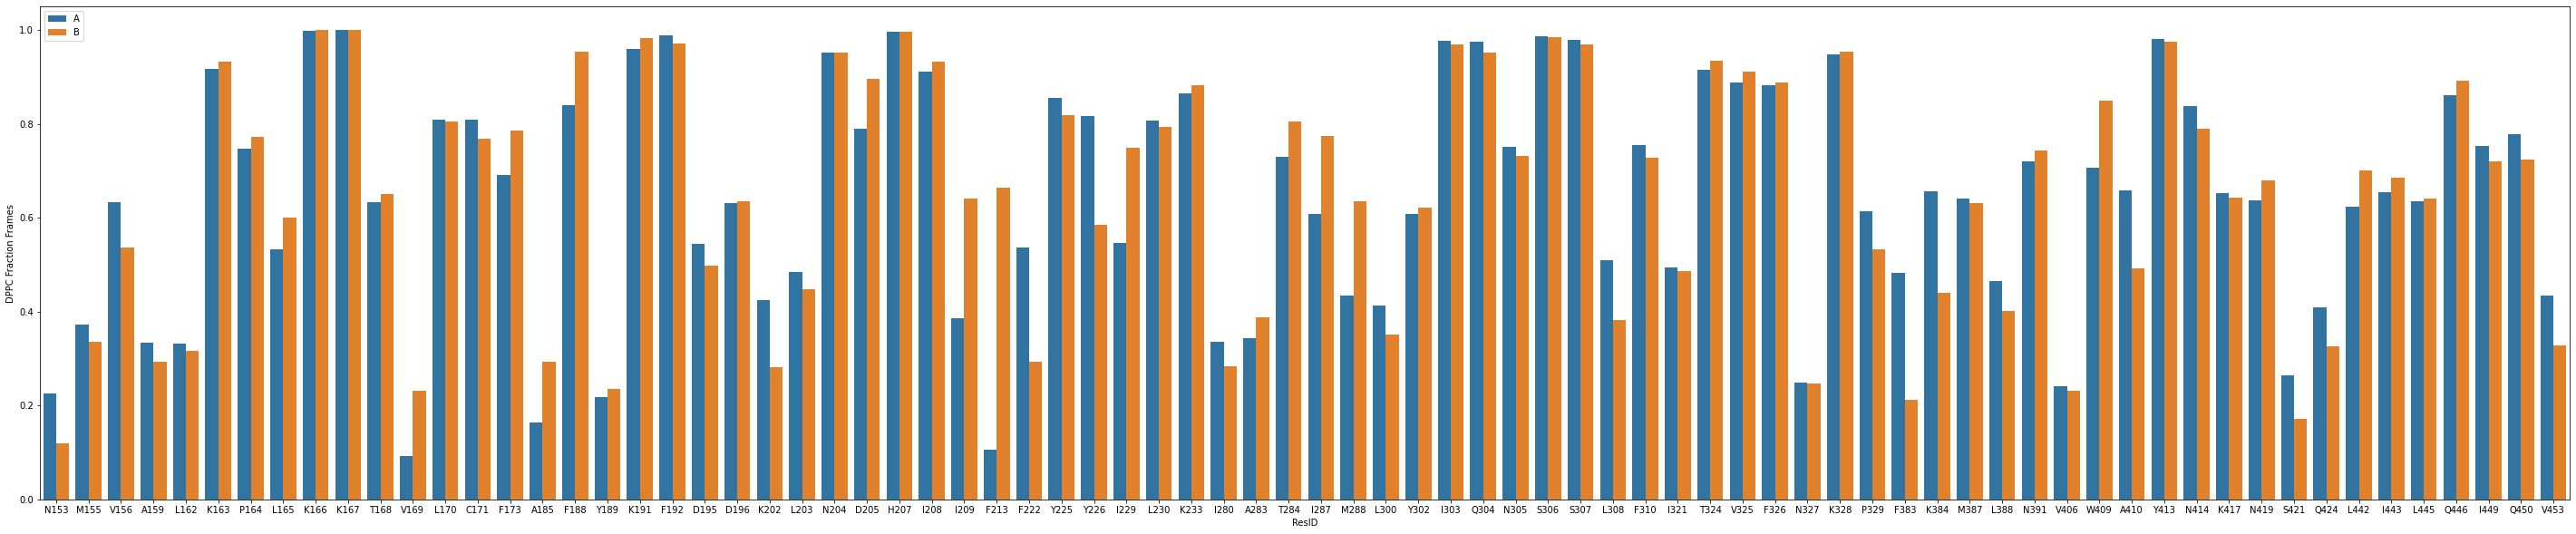

In [47]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_6v9z_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_6v9z, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_6v9z_melt_fig.savefig("6v9z DPPC Chain Count Sig Correct.png", dpi = 300)

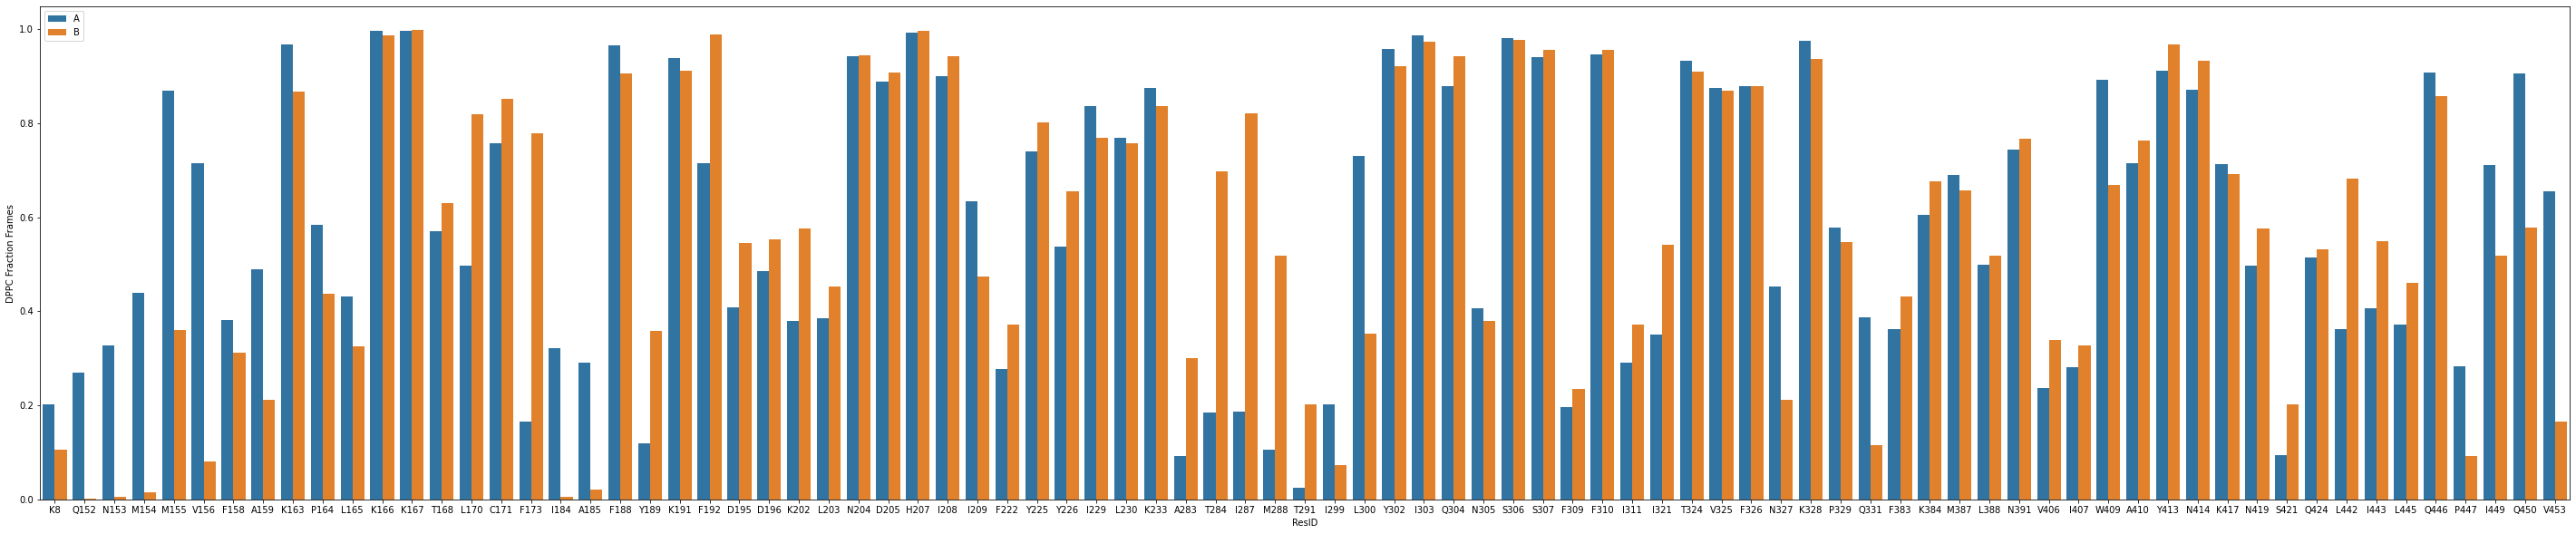

In [74]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_7t55_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_7t55, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_7t55_melt_fig.savefig("7t55 DPPC Chain Count Sig Correct.png", dpi = 300)

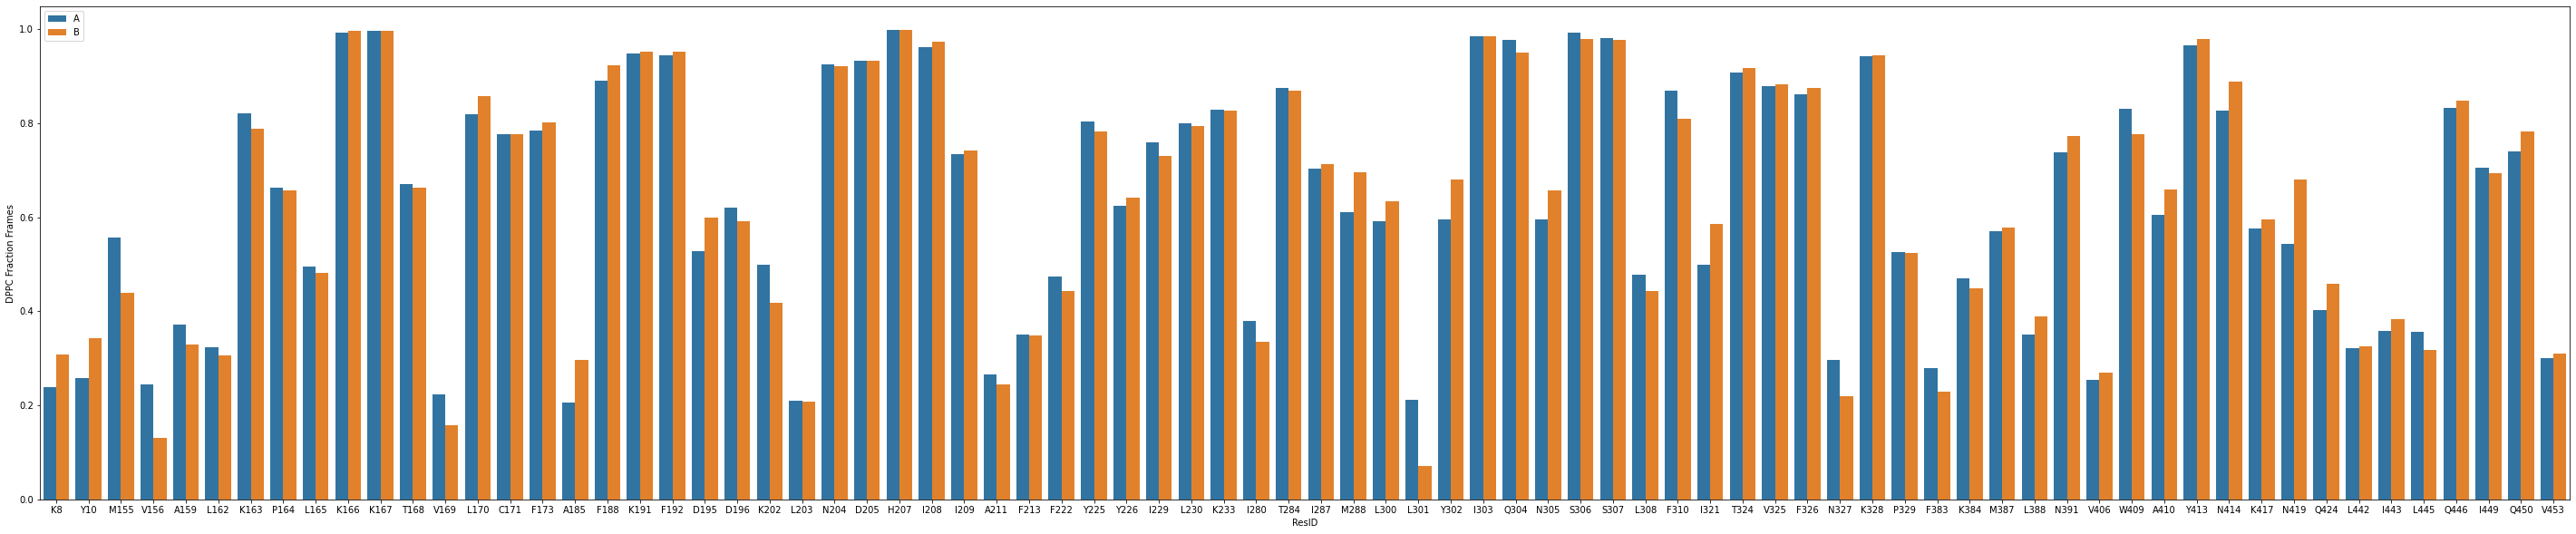

In [75]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_7t56_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_7t56, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_7t56_melt_fig.savefig("7t56 DPPC Chain Count Sig Correct.png", dpi = 300)

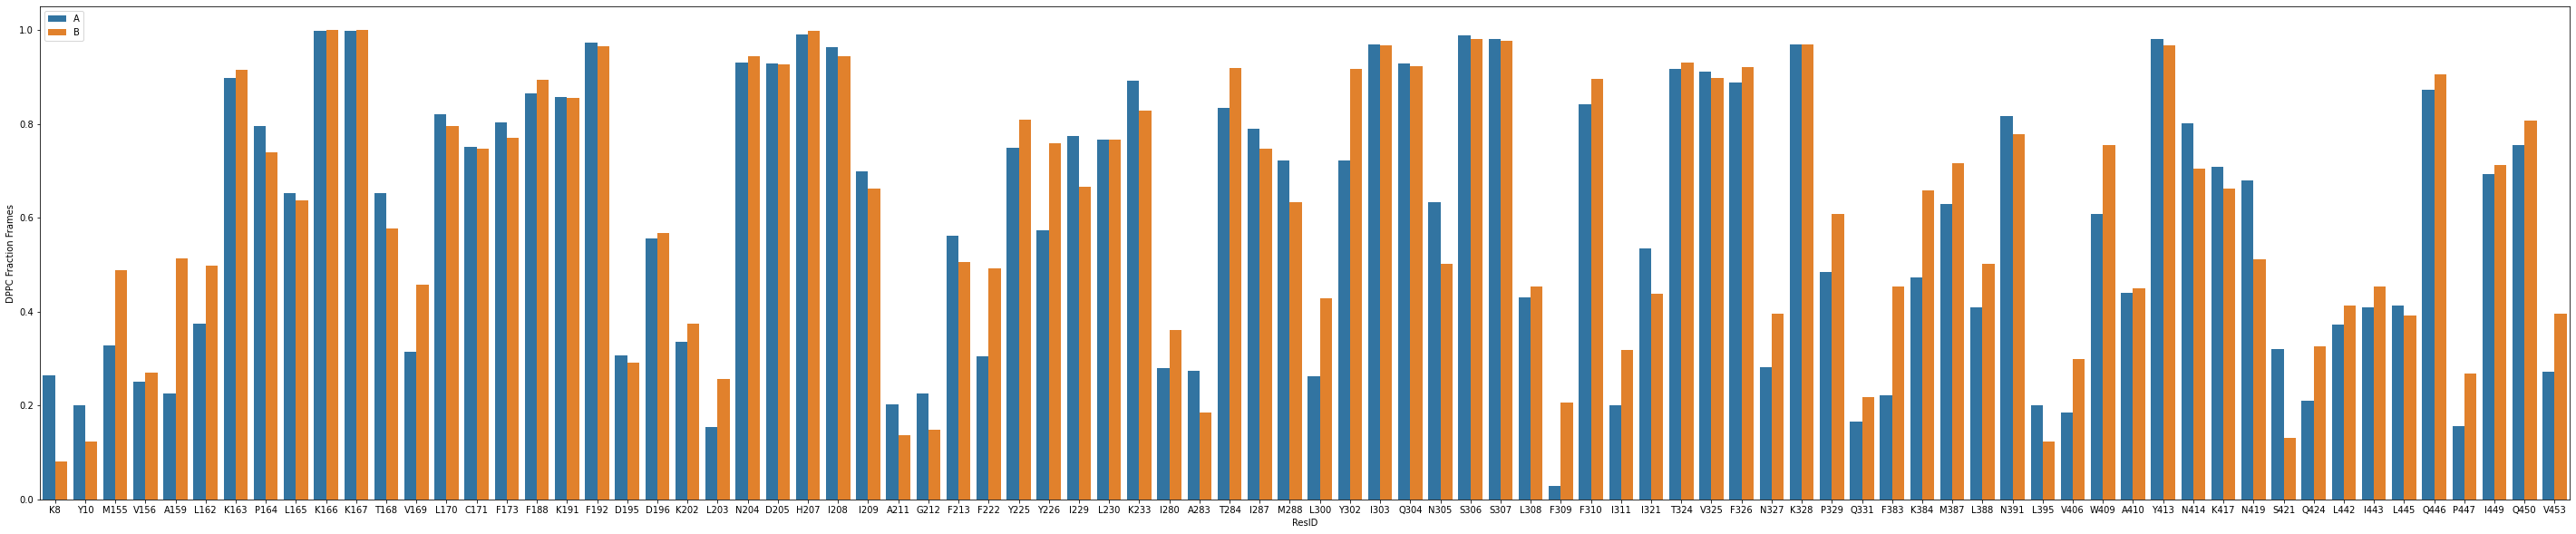

In [76]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_7t57_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_7t57, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_7t57_melt_fig.savefig("7t57 DPPC Chain Count Sig Correct.png", dpi = 300)

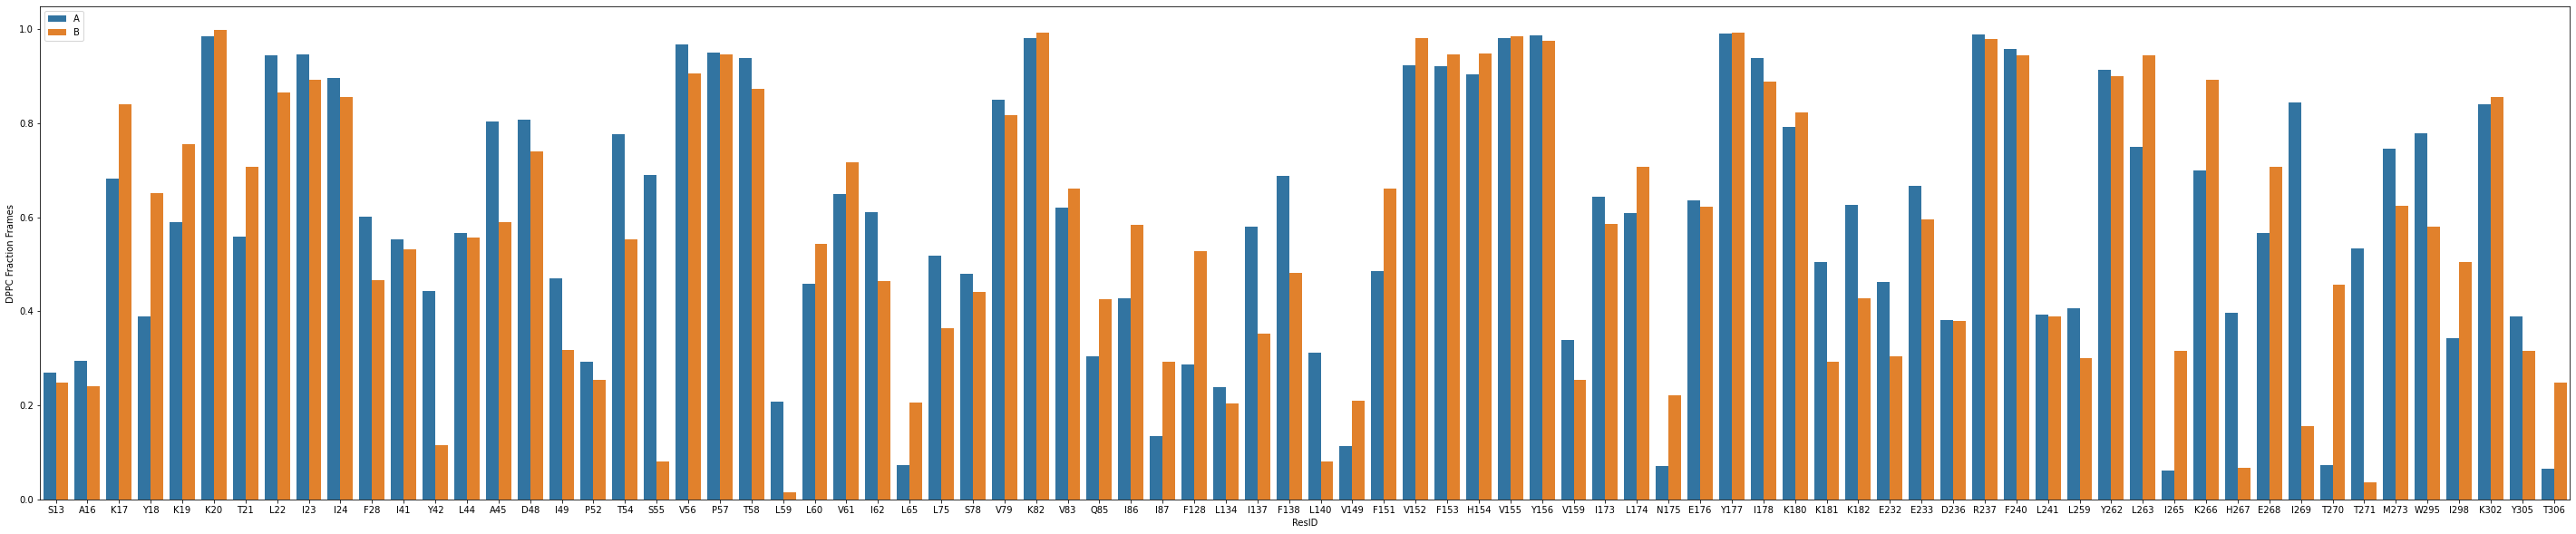

In [77]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_5l22_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_5l22, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_5l22_melt_fig.savefig("5l22 DPPC Chain Count Sig Correct.png", dpi = 300)

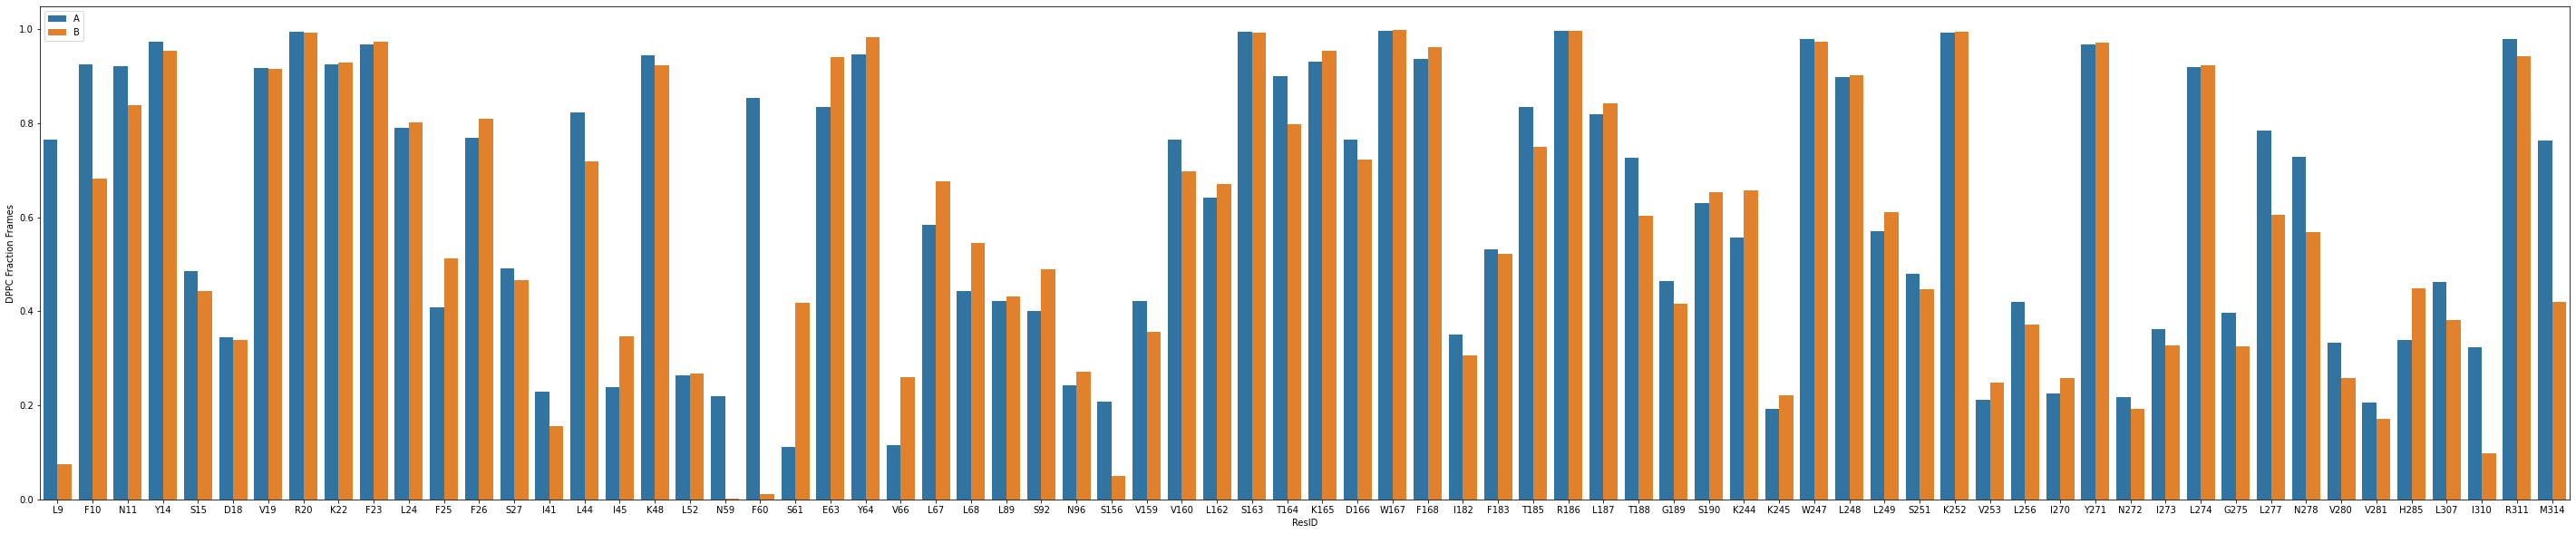

In [78]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_4pl0_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_4pl0, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_4pl0_melt_fig.savefig("4pl0 DPPC Chain Count Sig Correct.png", dpi = 300)

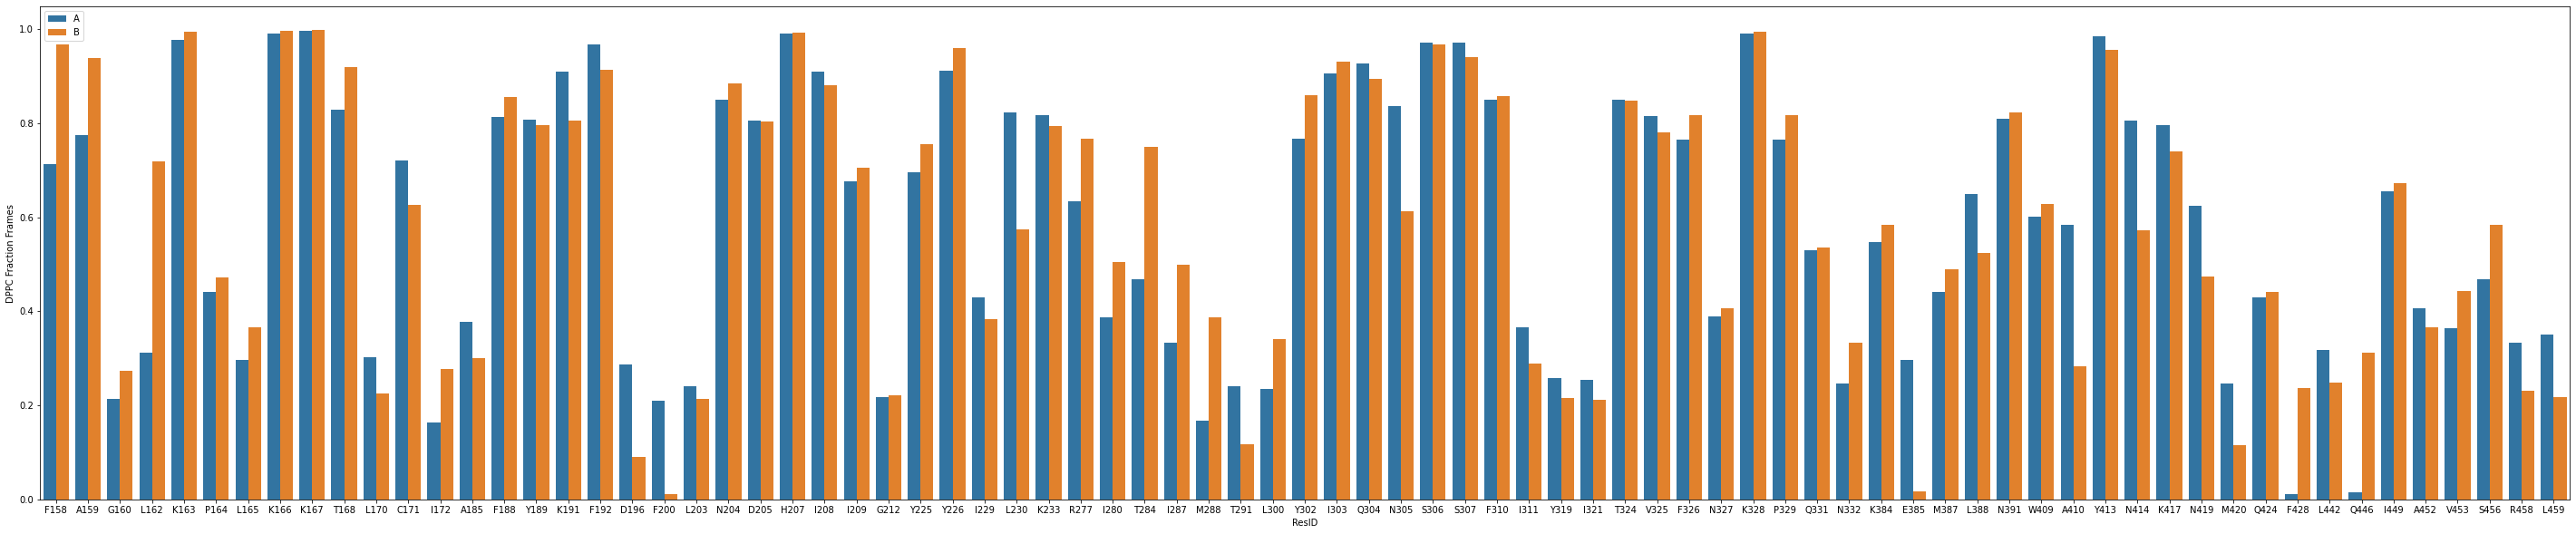

In [79]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_4s0f_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_4s0f, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_4s0f_melt_fig.savefig("4s0f DPPC Chain Count Sig Correct.png", dpi = 300)

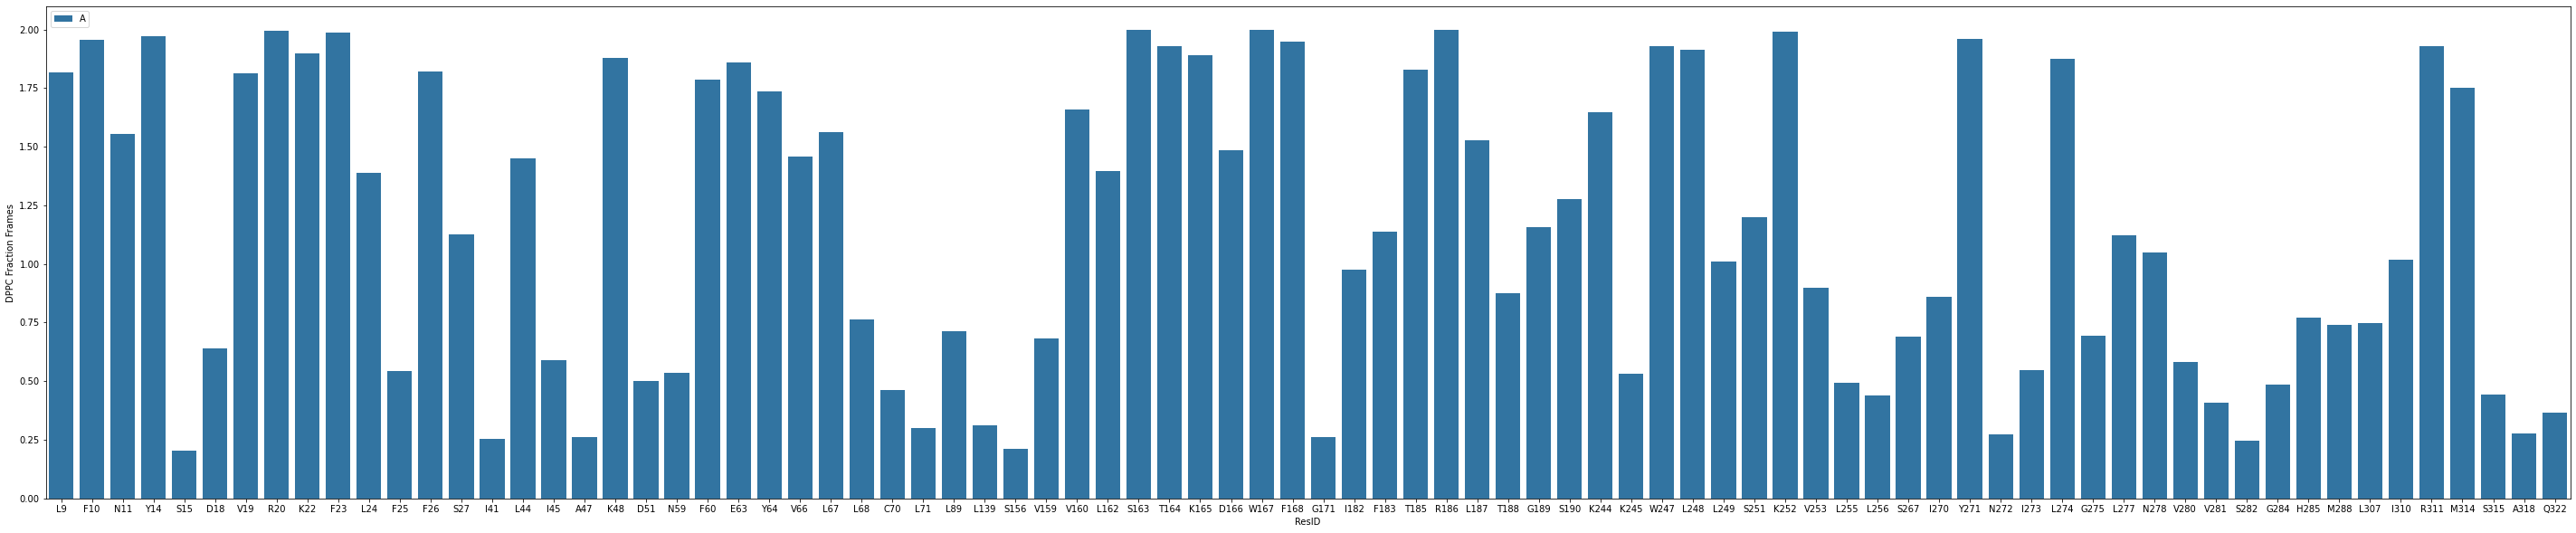

In [80]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_5ofp_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_5ofp, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_5ofp_melt_fig.savefig("5ofp DPPC Chain Count Sig Correct.png", dpi = 300)

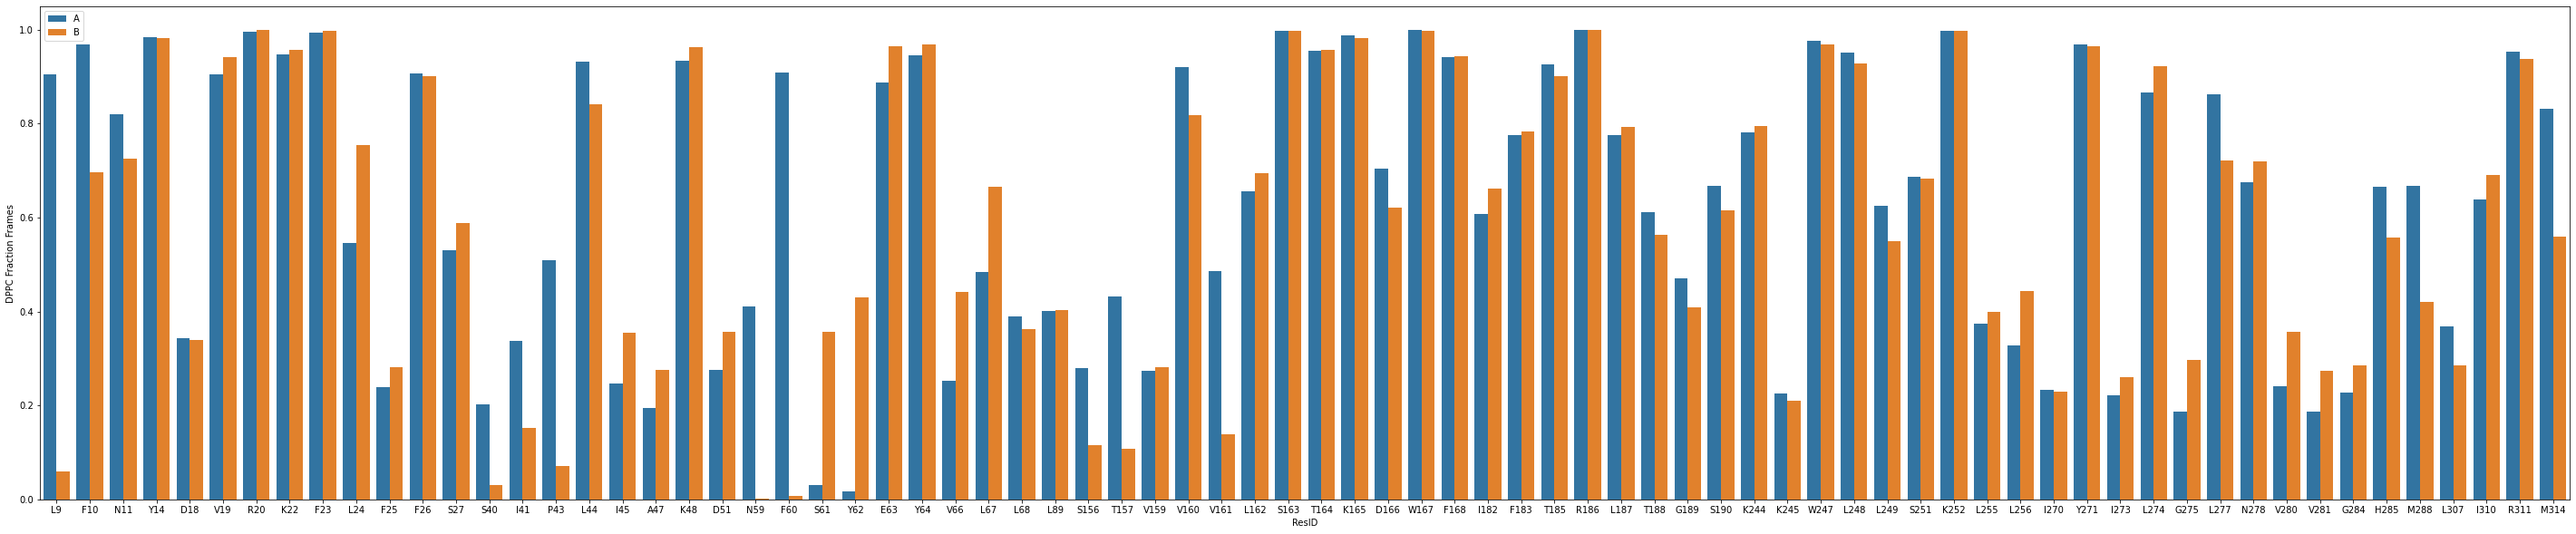

In [81]:
fig_dims = (50, 10)
fig, ax = plt.subplots(figsize=fig_dims)
new_count_5eg1_melt_fig = sns.barplot(x = "ResID", y = "Fraction_Frames", hue="ChainID", 
                                  data = new_5eg1, ax=ax).get_figure()
plt.xlabel("ResID")
plt.ylabel("DPPC Fraction Frames")
plt.legend(loc='upper left');
new_count_5eg1_melt_fig.savefig("5eg1 DPPC Chain Count Sig Correct.png", dpi = 300)

### Comments

4s0f - N-terminal domain (CLD domain) missing in crystal structure

### Monte Carlo Permutation Test - 6v9z

In [ ]:
# Get data
boot_data_6v9z = list(count_6v9z_melt["Fraction_Frames"])

In [ ]:
# Select enough of a subset so extreme values don't dominate the distribution
boot_test_6v9z = montecarlo(boot_data_6v9z,40,1000000)

In [ ]:
# Plot monte carlo test results
plt.hist(boot_test_6v9z,bins=100);
plt.title("Bootstrap Test")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Bootstrap Test 6v9z", dpi=150)

In [ ]:
#Plot actual distribution for chain A and B lipid interaction values for 6v9z
plt.hist(A_B_diff_6v9z.values(),bins=50);
plt.title("Actual 6v9z Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual Differences 6v9z", dpi=150)

In [ ]:
#Calculate p-values for chain differences for 6v9z
p_val_6v9z_boot = p_val(A_B_diff_6v9z,1000000,boot_test_6v9z)

In [ ]:
#Bonferroni correction p-values with sig level 0.05 for 6v9z
sig_p_val_6v9z_boot = sig_p_val(p_val_6v9z_boot,0.05)

3 amino acids with a significant (5% SL) differences between chains:\
I202, F206, and F376

### Monte Carlo Permutation Test - 7t55

In [ ]:
# Get data
boot_data_7t55 = list(count_7t55_melt["Fraction_Frames"])

In [ ]:
# Select enough of a subset so extreme values don't dominate the distribution
boot_test_7t55 = montecarlo(boot_data_7t55,34,1000000)

In [ ]:
# Plot monte carlo test results
plt.hist(boot_test_7t55,bins=100);
plt.title("Bootstrap Test")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Bootstrap Test 7t55", dpi=150)

In [ ]:
#Plot actual distribution for chain A and B lipid interaction values for 6v9z
plt.hist(A_B_diff_7t55.values(),bins=50);
plt.title("Actual 7t55 Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual Differences 7t55", dpi=150)

In [ ]:
#Calculate p-values for chain differences for 7t55
p_val_7t55_boot = p_val(A_B_diff_7t55,1000000,boot_test_7t55)

In [ ]:
#Bonferroni correction p-values with sig level 0.05 for 7t55
sig_p_val_7t55_boot = sig_p_val(p_val_7t55_boot,0.05)

16 amino acids with a significant (5% SL) differences between chains:\
N146, M147, M148, V149, A152, L163, F166, I177, F185, T277, I280, M281, L293, L435, Q443, V446

### Monte Carlo Permutation Test - 7t56

In [ ]:
# Get data
boot_data_7t56 = list(count_7t56_melt["Fraction_Frames"])

In [ ]:
# Extract a dictionary of lipid interaction values by amino acid for 7t56
chain_A_7t56, chain_B_7t56 = chain_dic(count_7t56_melt)

In [ ]:
# Select enough of a subset so extreme values don't dominate the distribution
boot_test_7t56 = montecarlo(boot_data_7t56,36,1000000)

In [ ]:
# Plot monte carlo test results
plt.hist(boot_test_7t56,bins=100);
plt.title("Bootstrap Test")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Bootstrap Test 7t56", dpi=150)

In [ ]:
#Actual chain difference for 7t56
A_B_diff_7t56,unique_A_7t56,unique_B_7t56 = chain_pair_vals(chain_A_7t56,chain_B_7t56)

In [ ]:
#Plot actual distribution for chain A and B lipid interaction values for 6v9z
plt.hist(A_B_diff_7t56.values(),bins=50);
plt.title("Actual 7t56 Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual Differences 7t56", dpi=150)

In [ ]:
#Calculate p-values for chain differences for 7t56
p_val_7t56_boot = p_val(A_B_diff_7t56,1000000,boot_test_7t56)

In [ ]:
#Bonferroni correction p-values with sig level 0.1 for 7t55
sig_p_val_7t56_boot = sig_p_val(p_val_7t56_boot,0.05)

No amino acids with significant differences

### Monte Carlo Permutation Test - 7t57

In [ ]:
# Get data
boot_data_7t57 = list(count_7t57_melt["Fraction_Frames"])

In [ ]:
# Extract a dictionary of lipid interaction values by amino acid for 7t56
chain_A_7t57, chain_B_7t57 = chain_dic(count_7t57_melt)

In [ ]:
# Select enough of a subset so extreme values don't dominate the distribution
boot_test_7t57 = montecarlo(boot_data_7t57,34,1000000)

In [ ]:
# Plot monte carlo test results
plt.hist(boot_test_7t57,bins=100);
plt.title("Bootstrap Test")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Bootstrap Test 7t57", dpi=150)

In [ ]:
#Actual chain difference for 7t57
A_B_diff_7t57,unique_A_7t57,unique_B_7t57 = chain_pair_vals(chain_A_7t57,chain_B_7t57)

In [ ]:
#Plot actual distribution for chain A and B lipid interaction values for 6v9z
plt.hist(A_B_diff_7t57.values(),bins=50);
plt.title("Actual 7t57 Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual Differences 7t57", dpi=150)

In [ ]:
#Calculate p-values for chain differences for 7t56
p_val_7t57_boot = p_val(A_B_diff_7t57,1000000,boot_test_7t57)

In [ ]:
#Bonferroni correction p-values with sig level 0.1 for 7t55
sig_p_val_7t57_boot = sig_p_val(p_val_7t57_boot,0.05)

Only 1 amino acid with significant difference (5% SL) between chains:\
A152

### Monte Carlo PermutationTest - 5l22

In [ ]:
# Get data
boot_data_5l22 = list(count_5l22_melt["Fraction_Frames"])

In [ ]:
# Extract a dictionary of lipid interaction values by amino acid for 7t56
chain_A_5l22, chain_B_5l22 = chain_dic(count_5l22_melt)

155 amino acids for chain A and B

In [ ]:
# Select enough of a subset so extreme values don't dominate the distribution
boot_test_5l22 = montecarlo(boot_data_5l22,32,1000000)

In [ ]:
# Plot monte carlo test results
plt.hist(boot_test_5l22,bins=100);
plt.title("Bootstrap Test")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Bootstrap Test 5l22", dpi=150)

In [ ]:
#Actual chain difference for 5l22
A_B_diff_5l22,unique_A_5l22,unique_B_5l22 = chain_pair_vals(chain_A_5l22,chain_B_5l22)

In [ ]:
#Plot actual distribution for chain A and B lipid interaction values for 6v9z
plt.hist(A_B_diff_5l22.values(),bins=50);
plt.title("Actual 5l22 Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual Differences 5l22", dpi=150)

In [ ]:
#Calculate p-values for chain differences for 5l22
p_val_5l22_boot = p_val(A_B_diff_5l22,1000000,boot_test_5l22)

In [ ]:
#Bonferroni correction p-values with sig level 0.05 for 5l22
sig_p_val_5l22_boot = sig_p_val(p_val_5l22_boot,0.05)

6 amino acids with significant difference (5% SL) between chains:\
Y42, S55, H267, I269, T270, T271

### Monte Carlo Permutation Test - 4s0f

In [ ]:
# Get data
boot_data_4s0f = list(count_4s0f_melt["Fraction_Frames"])

In [ ]:
# Extract a dictionary of lipid interaction values by amino acid for 4s0f
chain_A_4s0f, chain_B_4s0f = chain_dic(count_4s0f_melt)

In [ ]:
# Select enough of a subset so extreme values don't dominate the distribution
boot_test_4s0f = montecarlo(boot_data_4s0f,30,1000000)

In [ ]:
# Plot monte carlo test results
plt.hist(boot_test_4s0f,bins=100);
plt.title("Bootstrap Test")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Bootstrap Test 4s0f", dpi=150)

In [ ]:
#Actual chain difference for 4s0f
A_B_diff_4s0f,unique_A_4s0f,unique_B_4s0f = chain_pair_vals(chain_A_4s0f,chain_B_4s0f)

In [ ]:
#Plot actual distribution for chain A and B lipid interaction values for 4s0f
plt.hist(A_B_diff_4s0f.values(),bins=50);
plt.title("Actual 4s0f Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual Differences 4s0f", dpi=150)

In [ ]:
#Calculate p-values for chain differences for 4s0f
p_val_4s0f_boot = p_val(A_B_diff_4s0f,1000000,boot_test_4s0f)

In [ ]:
#Bonferroni correction p-values with sig level 0.05 for 4s0f
sig_p_val_4s0f_boot = sig_p_val(p_val_4s0f_boot,0.05)

3 amino acids with significant difference (5% SL) between chains:\
L162, A410, Q446

### Monte Carlo Permutation Test - 4p10

In [ ]:
# Get data
boot_data_4pl0 = list(count_4pl0_melt["Fraction_Frames"])

In [ ]:
# Extract a dictionary of lipid interaction values by amino acid for 4pl0
chain_A_4pl0, chain_B_4pl0 = chain_dic(count_4pl0_melt)

In [ ]:
# Select enough of a subset so extreme values don't dominate the distribution
boot_test_4pl0 = montecarlo(boot_data_4pl0,28,1000000)

In [ ]:
# Plot monte carlo test results
plt.hist(boot_test_4pl0,bins=100);
plt.title("Bootstrap Test")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Bootstrap Test 4pl0", dpi=150)

In [ ]:
#Actual chain difference for 4pl0
A_B_diff_4pl0,unique_A_4pl0,unique_B_4pl0 = chain_pair_vals(chain_A_4pl0,chain_B_4pl0)

In [ ]:
#Plot actual distribution for chain A and B lipid interaction values for 4pl0
plt.hist(A_B_diff_4pl0.values(),bins=50);
plt.title("Actual 4pl0 Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual Differences 4pl0", dpi=150)

In [ ]:
#Calculate p-values for chain differences for 4pl0
p_val_4pl0_boot = p_val(A_B_diff_4pl0,1000000,boot_test_4pl0)

In [ ]:
#Bonferroni correction p-values with sig level 0.05 for 4pl0
sig_p_val_4pl0_boot = sig_p_val(p_val_4pl0_boot,0.05)

4 amino acids with significant difference (5% SL) between chains:\
L9, F60, S61, M314

### Monte Carlo Permutation Test - 5eg1

In [ ]:
# Get data
boot_data_5eg1 = list(count_5eg1_melt["Fraction_Frames"])

In [ ]:
# Extract a dictionary of lipid interaction values by amino acid for 5eg1
chain_A_5eg1, chain_B_5eg1 = chain_dic(count_5eg1_melt)

In [ ]:
# Select enough of a subset so extreme values don't dominate the distribution
boot_test_5eg1 = montecarlo(boot_data_5eg1,30,1000000)

In [ ]:
# Plot monte carlo test results
plt.hist(boot_test_5eg1,bins=100);
plt.title("Bootstrap Test")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Bootstrap Test 5eg1", dpi=150)

In [ ]:
#Actual chain difference for 5eg1
A_B_diff_5eg1,unique_A_5eg1,unique_B_5eg1 = chain_pair_vals(chain_A_5eg1,chain_B_5eg1)

In [ ]:
#Plot actual distribution for chain A and B lipid interaction values for 5eg1
plt.hist(A_B_diff_5eg1.values(),bins=50);
plt.title("Actual 5eg1 Difference Values")
plt.xlabel("Mean Difference")
plt.ylabel("Frequency");
plt.savefig("Actual Differences 5eg1", dpi=150)

In [ ]:
#Calculate p-values for chain differences for 5eg1
p_val_5eg1_boot = p_val(A_B_diff_5eg1,1000000,boot_test_5eg1)

In [ ]:
#Bonferroni correction p-values with sig level 0.05 for 5eg1
sig_p_val_5eg1_boot = sig_p_val(p_val_5eg1_boot,0.05)

8 amino acids with significant difference (5% SL) between chains:\
L9, P43, N59, F60, S61, Y62, T157, V161